In [52]:
import warnings                               
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pytz

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# **Introduction to the data**

In [53]:
# Load the dataset
data_path = 'EVChargingStationUsage.csv'  # Update this path if needed
data = pd.read_csv(data_path)

# Display the first few rows of the dataset
data.head()

Station Name          MAC Address           Org Name  \
0  PALO ALTO CA / HAMILTON #1  000D:6F00:015A:9D76  City of Palo Alto   
1  PALO ALTO CA / HAMILTON #1  000D:6F00:015A:9D76  City of Palo Alto   
2  PALO ALTO CA / HAMILTON #1  000D:6F00:015A:9D76  City of Palo Alto   
3  PALO ALTO CA / HAMILTON #1  000D:6F00:015A:9D76  City of Palo Alto   
4  PALO ALTO CA / HAMILTON #1  000D:6F00:015A:9D76  City of Palo Alto   

        Start Date Start Time Zone         End Date End Time Zone  \
0  7/29/2011 20:17             PDT  7/29/2011 23:20           PDT   
1   7/30/2011 0:00             PDT   7/30/2011 0:02           PDT   
2   7/30/2011 8:16             PDT  7/30/2011 12:34           PDT   
3  7/30/2011 14:51             PDT  7/30/2011 16:55           PDT   
4  7/30/2011 18:51             PDT  7/30/2011 20:03           PDT   

  Transaction Date (Pacific Time) Total Duration (hh:mm:ss)  \
0                 7/29/2011 23:20                   3:03:32   
1                  7/30/2011 0:02                   0:02:06   
2                 7/30/2011 12:34                   4:17:32   
3                 7/30/2011 16:55                   2:03:24   
4                 7/30/2011 20:03                   1:11:24   

  Charging Time (hh:mm:ss)  ...   Longitude  Currency  Fee  \
0                  1:54:03  ... -122.160309       USD  0.0   
1                  0:01:54  ... -122.160309       USD  0.0   
2                  4:17:28  ... -122.160309       USD  0.0   
3                  2:02:58  ... -122.160309       USD  0.0   
4                  0:43:54  ... -122.160309       USD  0.0   

              Ended By  Plug In Event Id Driver Postal Code  User ID County  \
0  Plug Out at Vehicle                 3            95124.0   3284.0    NaN   
1             Customer                 4            94301.0   4169.0    NaN   
2  Plug Out at Vehicle                 5            94301.0   4169.0    NaN   
3             Customer                 6            94302.0   2545.0    NaN   
4  Plug Out at Vehicle                 7            94043.0   3765.0    NaN   

  System S/N Model Number  
0        NaN          NaN  
1        NaN          NaN  
2        NaN          NaN  
3        NaN          NaN  
4        NaN          NaN  

[5 rows x 33 columns]

## Data Preparation and Cleaning

In [54]:
# Overview of the dataset
data.info()
print('-' * 100)
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259415 entries, 0 to 259414
Data columns (total 33 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Station Name                     259415 non-null  object 
 1   MAC Address                      259415 non-null  object 
 2   Org Name                         259415 non-null  object 
 3   Start Date                       259415 non-null  object 
 4   Start Time Zone                  259415 non-null  object 
 5   End Date                         259415 non-null  object 
 6   End Time Zone                    259415 non-null  object 
 7   Transaction Date (Pacific Time)  259206 non-null  object 
 8   Total Duration (hh:mm:ss)        259415 non-null  object 
 9   Charging Time (hh:mm:ss)         259415 non-null  object 
 10  Energy (kWh)                     259415 non-null  float64
 11  GHG Savings (kg)                 259415 non-null  float64
 12  Ga

Energy (kWh)  GHG Savings (kg)  Gasoline Savings (gallons)  \
count  259415.000000     259415.000000               259415.000000   
mean        8.544277          3.588596                    1.072306   
std         7.185462          3.017894                    0.901776   
min         0.010000          0.004000                    0.001000   
25%         3.784000          1.589000                    0.475000   
50%         6.868634          2.885000                    0.862000   
75%        11.458340          4.813000                    1.438000   
max        97.360000         40.891000                   12.219000   

         Port Number       EVSE ID    Postal Code       Latitude  \
count  259415.000000  1.804670e+05  259415.000000  259415.000000   
mean        1.591627  1.462973e+05   94302.315768      37.439565   
std         0.491534  2.429677e+05       1.941657       0.009621   
min         1.000000  3.792000e+03   94301.000000      37.422104   
25%         1.000000  4.358300e+04   94301.000000      37.428318   
50%         2.000000  1.074270e+05   94301.000000      37.444489   
75%         2.000000  1.745590e+05   94303.000000      37.446613   
max         2.000000  5.535441e+06   94306.000000      37.449375   

           Longitude            Fee  Plug In Event Id  Driver Postal Code  \
count  259415.000000  259415.000000      2.594150e+05       251013.000000   
mean     -122.151264       1.097481      1.188685e+08        94170.308255   
std         0.015382       1.934408      4.057750e+08         4249.837126   
min      -122.163239       0.000000      1.000000e+00         1013.000000   
25%      -122.162170       0.000000      1.573000e+03        94087.000000   
50%      -122.158272       0.000000      3.573000e+03        94304.000000   
75%      -122.145699       1.640000      6.340000e+03        94804.000000   
max      -122.112480      84.560000      1.609436e+09        99354.000000   

         System S/N  
count  1.804670e+05  
mean   1.443790e+11  
std    2.483280e+10  
min    1.023100e+11  
25%    1.231100e+11  
50%    1.427410e+11  
75%    1.705410e+11  
max    2.002410e+11

In [55]:
# Check for missing values
def check_missing_values(df):
    missing_cols = df.isnull().sum()
    print("Missing values per column:\n", missing_cols[missing_cols > 0])

    missing_rows = df.isnull().sum(axis=1)
    total_missing = df.isnull().sum().sum()

    print(f"\nTotal missing values: {total_missing}")
    print("Total number of rows with missing values:", len(missing_rows[missing_rows > 0]))
    print("Total number of columns with missing values:", len(missing_cols[missing_cols > 0]))
    return

check_missing_values(data)

Missing values per column:
 Transaction Date (Pacific Time)      209
Port Type                              9
EVSE ID                            78948
Currency                            1788
Ended By                             248
Driver Postal Code                  8402
User ID                             7677
County                             84665
System S/N                         78948
Model Number                       78948
dtype: int64

Total missing values: 339842
Total number of rows with missing values: 89969
Total number of columns with missing values: 10


In [56]:
# Data cleaning
threshold = 8000
cols_to_drop = data.columns[data.isnull().sum() > threshold]
data = data.drop(columns=cols_to_drop)

if 'Port Type' in data.columns:
    data['Port Type'] = data['Port Type'].fillna(data['Port Type'].mode()[0])

if 'Model Number' in data.columns:
    data['Model Number'] = data['Model Number'].fillna('Unknown')

if 'User ID' in data.columns:
    data = data.dropna(subset=['User ID'])
    data = data[pd.to_numeric(data['User ID'], errors='coerce').notnull()]
    data['User ID'] = data['User ID'].astype(int)

data = data.dropna()
print("Remaining missing values after cleaning:")
check_missing_values(data)

Remaining missing values after cleaning:
Missing values per column:
 Series([], dtype: int64)

Total missing values: 0
Total number of rows with missing values: 0
Total number of columns with missing values: 0


In [57]:
# Convert datetime columns to datetime objects
data['Start Date'] = pd.to_datetime(data['Start Date'])
data['End Date'] = pd.to_datetime(data['End Date'], errors='coerce')
data['Transaction Date (Pacific Time)'] = pd.to_datetime(data['Transaction Date (Pacific Time)'], errors='coerce')

# Convert time durations to timedelta
data['Total Duration (hh:mm:ss)'] = pd.to_timedelta(data['Total Duration (hh:mm:ss)'])
data['Charging Time (hh:mm:ss)'] = pd.to_timedelta(data['Charging Time (hh:mm:ss)'])

# Convert durations to minutes
data['Total Charging Time (min)'] = data['Charging Time (hh:mm:ss)'].dt.total_seconds() / 60
data['Total Duration (min)'] = data['Total Duration (hh:mm:ss)'].dt.total_seconds() / 60

# Calculate energy usage per minute
data['kWh per min'] = data['Energy (kWh)'] / data['Total Charging Time (min)']

# Add day of the week
data['Day of week'] = data['Start Date'].dt.dayofweek

# Add weekend vs. weekday column
data['Weekend/Weekday'] = data['Day of week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Add day vs. night column
data['Hour'] = data['Start Date'].dt.hour
data['Day/Night'] = data['Hour'].apply(lambda x: 'Day' if 6 <= x < 18 else 'Night')

## Feature Engineering for Clustering

In [58]:
# Map time zones
tz_mapping = {
    'PDT': 'US/Pacific',
    'PST': 'US/Pacific',
    'UTC': 'UTC'
}

# Localize and convert times to UTC
def localize_to_timezone(row, datetime_col, tz_col):
    tz_name = row[tz_col]
    timezone = pytz.timezone(tz_mapping.get(tz_name))
    return row[datetime_col].tz_localize(timezone, ambiguous='NaT', nonexistent='NaT')

data['Start Date Localized'] = data.apply(lambda row: localize_to_timezone(row, 'Start Date', 'Start Time Zone'), axis=1)
data['End Date Localized'] = data.apply(lambda row: localize_to_timezone(row, 'End Date', 'End Time Zone'), axis=1)
data['Start Date UTC'] = pd.to_datetime(data['Start Date Localized'], utc=True)
data['End Date UTC'] = pd.to_datetime(data['End Date Localized'], utc=True)

# Split events into hourly segments
def split_event_into_hours(row):
    start = row['Start Date UTC']
    end = row['End Date UTC']
    total_charging_time = row['Total Charging Time (min)']
    total_duration = row['Total Duration (min)']
    kWh_per_min = row['kWh per min']

    hourly_rows = []
    current_time = start.replace(minute=0, second=0, microsecond=0)

    while current_time < end:
        next_hour = current_time + pd.Timedelta(hours=1)
        charging_minutes = min((next_hour - start).total_seconds() / 60, total_charging_time) if start < next_hour else 0
        occupied_minutes = min((next_hour - start).total_seconds() / 60, total_duration) if start < next_hour else 0

        hourly_rows.append({
            'User ID': row['User ID'],
            'Station Name': row['Station Name'],
            'Hour': current_time,
            'Charging Time (min)': charging_minutes,
            'Occupied Time (min)': occupied_minutes,
            'Energy (kWh)': charging_minutes * kWh_per_min
        })

        current_time = next_hour

    return pd.DataFrame(hourly_rows)

hourly_data = pd.concat(data.apply(split_event_into_hours, axis=1).tolist(), ignore_index=True)

In [59]:
# Group hourly data by User ID, Station Name, Weekend/Weekday, and Day/Night
hourly_data['Day of week'] = hourly_data['Hour'].dt.dayofweek
hourly_data['Weekend/Weekday'] = hourly_data['Day of week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
hourly_data['Hour of day'] = hourly_data['Hour'].dt.hour
hourly_data['Day/Night'] = hourly_data['Hour of day'].apply(lambda x: 'Day' if 6 <= x < 18 else 'Night')

usage_patterns = hourly_data.groupby(['Station Name', 'Weekend/Weekday', 'Day/Night']).agg({
    'Charging Time (min)': 'sum',
    'Occupied Time (min)': 'sum',
    'Energy (kWh)': 'sum'
}).reset_index()

In [60]:
# Pivot the table for better readability
usage_pivot = usage_patterns.pivot_table(index=['Station Name'], columns=['Weekend/Weekday', 'Day/Night'],
                                                   values=['Charging Time (min)', 'Occupied Time (min)', 'Energy (kWh)'],
                                                   fill_value=0)

# Flatten the multi-level columns for easier access
usage_pivot.columns = ['_'.join(col).strip() for col in usage_pivot.columns.values]

# Display the pivot table
print("Usage Patterns (Weekend vs Weekday, Day vs Night):")
usage_pivot

Usage Patterns (Weekend vs Weekday, Day vs Night):


Charging Time (min)_Weekday_Day  \
Station Name                                                      
PALO ALTO CA / BRYANT # 1                          4.044800e+03   
PALO ALTO CA / BRYANT #1                           1.517255e+06   
PALO ALTO CA / BRYANT #2                           1.605358e+06   
PALO ALTO CA / BRYANT #3                           3.643064e+05   
PALO ALTO CA / BRYANT #4                           1.642677e+05   
PALO ALTO CA / BRYANT #5                           2.121966e+05   
PALO ALTO CA / BRYANT #6                           3.984481e+05   
PALO ALTO CA / CAMBRIDGE #1                        8.838196e+05   
PALO ALTO CA / CAMBRIDGE #2                        7.882662e+05   
PALO ALTO CA / CAMBRIDGE #3                        1.950987e+05   
PALO ALTO CA / CAMBRIDGE #4                        8.740368e+04   
PALO ALTO CA / CAMBRIDGE #5                        1.614629e+05   
PALO ALTO CA / HAMILTON #1                         1.595009e+06   
PALO ALTO CA / HAMILTON #2                         2.739938e+06   
PALO ALTO CA / HIGH #1                             7.403736e+05   
PALO ALTO CA / HIGH #2                             4.130390e+05   
PALO ALTO CA / HIGH #3                             4.910650e+05   
PALO ALTO CA / HIGH #4                             1.078427e+06   
PALO ALTO CA / MPL #1                              2.043305e+05   
PALO ALTO CA / MPL #2                              3.381223e+05   
PALO ALTO CA / MPL #3                              3.402715e+05   
PALO ALTO CA / MPL #4                              9.356162e+05   
PALO ALTO CA / MPL #5                              7.492402e+05   
PALO ALTO CA / MPL #6                              9.366152e+05   
PALO ALTO CA / RINCONADA LIB 1                     7.656309e+05   
PALO ALTO CA / RINCONADA LIB 2                     7.171420e+05   
PALO ALTO CA / RINCONADA LIB 3                     7.263815e+05   
PALO ALTO CA / SHERMAN 1                           7.316000e+02   
PALO ALTO CA / SHERMAN 11                          5.900000e+01   
PALO ALTO CA / SHERMAN 14                          0.000000e+00   
PALO ALTO CA / SHERMAN 15                          0.000000e+00   
PALO ALTO CA / SHERMAN 17                          5.700000e+01   
PALO ALTO CA / SHERMAN 2                           0.000000e+00   
PALO ALTO CA / SHERMAN 3                           8.400000e+01   
PALO ALTO CA / SHERMAN 4                           0.000000e+00   
PALO ALTO CA / SHERMAN 5                           0.000000e+00   
PALO ALTO CA / SHERMAN 6                           0.000000e+00   
PALO ALTO CA / SHERMAN 7                           1.300000e+01   
PALO ALTO CA / SHERMAN 8                           0.000000e+00   
PALO ALTO CA / SHERMAN 9                           0.000000e+00   
PALO ALTO CA / TED THOMPSON #1                     1.116755e+06   
PALO ALTO CA / TED THOMPSON #2                     2.258655e+05   
PALO ALTO CA / TED THOMPSON #3                     1.585520e+05   
PALO ALTO CA / TED THOMPSON #4                     1.191680e+05   
PALO ALTO CA / WEBSTER #1                          1.691920e+06   
PALO ALTO CA / WEBSTER #2                          1.537489e+06   
PALO ALTO CA / WEBSTER #3                          9.263670e+05   

                                Charging Time (min)_Weekday_Night  \
Station Name                                                        
PALO ALTO CA / BRYANT # 1                            5.270067e+03   
PALO ALTO CA / BRYANT #1                             2.480607e+06   
PALO ALTO CA / BRYANT #2                             2.585631e+06   
PALO ALTO CA / BRYANT #3                             8.615624e+05   
PALO ALTO CA / BRYANT #4                             8.307107e+05   
PALO ALTO CA / BRYANT #5                             1.069603e+06   
PALO ALTO CA / BRYANT #6                             1.213480e+06   
PALO ALTO CA / CAMBRIDGE #1                          1.833093e+06   
PALO ALTO CA / CAMBRIDGE #2                          1.694

In [61]:
usage_pivot.to_csv('user_usage_patterns.csv')

## **Data visualization**

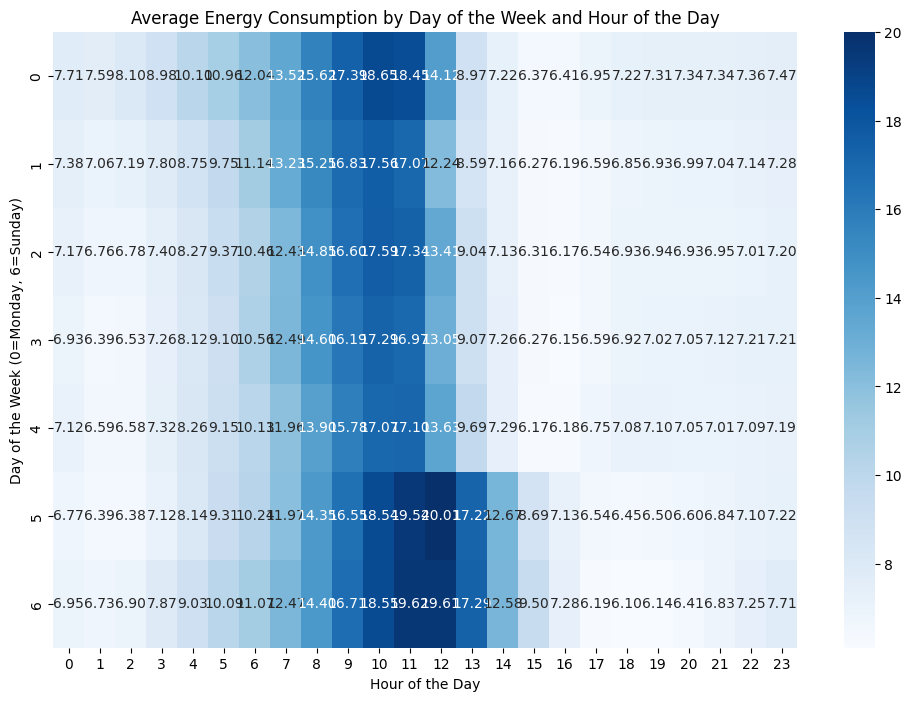

In [62]:
# Average Energy Consumption Heatmap by Day of the Week and Hour of the Day
plt.figure(figsize=(12, 8))
pivot_energy = hourly_data.pivot_table(values='Energy (kWh)', index='Day of week', columns='Hour of day', aggfunc='mean')
sns.heatmap(pivot_energy, cmap='Blues', annot=True, fmt=".2f")
plt.title('Average Energy Consumption by Day of the Week and Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week (0=Monday, 6=Sunday)')
plt.show()

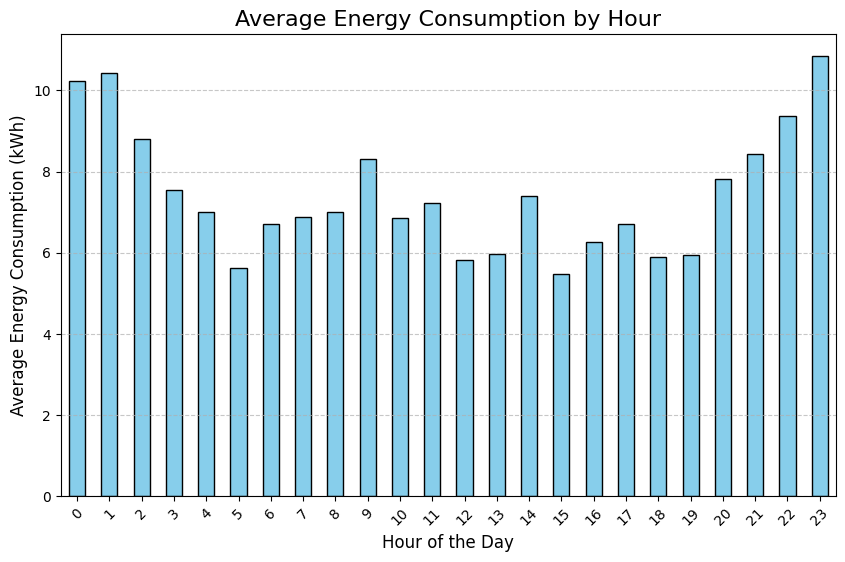

In [63]:
# Calculate the average energy consumption per hour across all users
user_hourly = data.pivot_table(index='Station Name', columns='Hour', values='Energy (kWh)', fill_value=0)
hourly_avg_energy = user_hourly.mean(axis=0)

# Plot the bar chart
plt.figure(figsize=(10, 6))
hourly_avg_energy.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Average Energy Consumption by Hour", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Average Energy Consumption (kWh)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

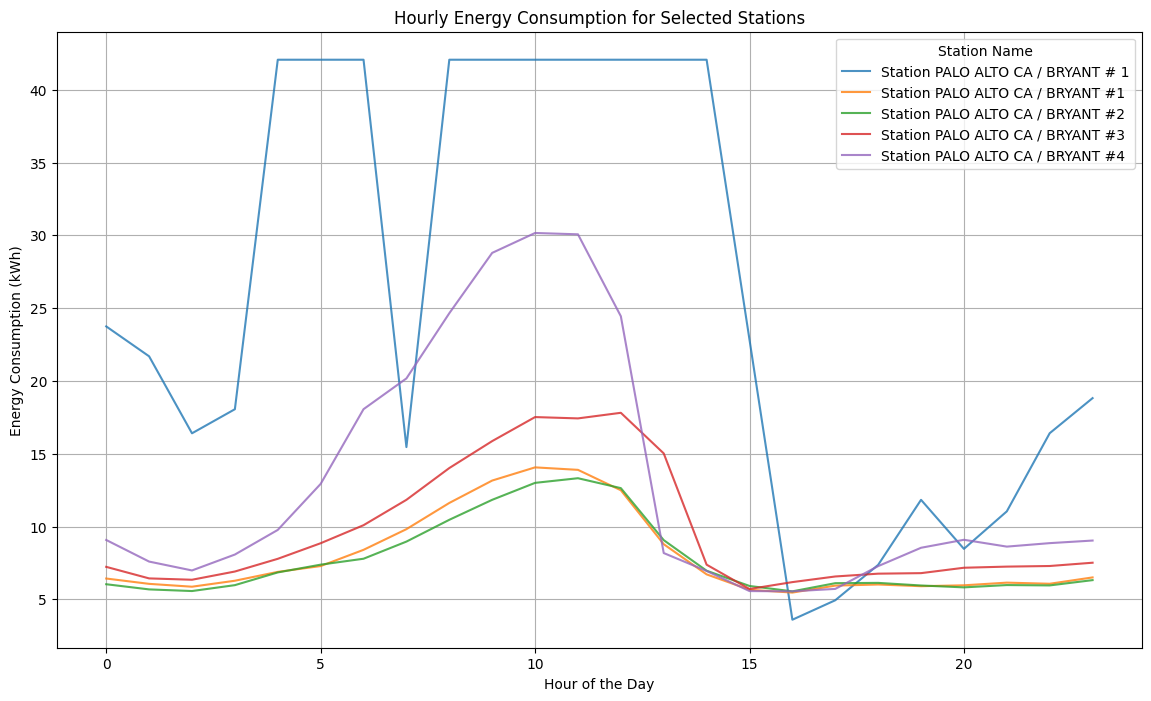

In [64]:
# Energy Usage Comparison for Multiple Stations by Hour:
station_groups = hourly_data.groupby(['Station Name', 'Hour of day']).agg({'Energy (kWh)': 'mean'}).reset_index()
stations_to_plot = station_groups['Station Name'].unique()[:5]

plt.figure(figsize=(14, 8))
for station in stations_to_plot:
    station_data = station_groups[station_groups['Station Name'] == station]
    plt.plot(station_data['Hour of day'], station_data['Energy (kWh)'], label=f'Station {station}', alpha=0.8)

plt.title('Hourly Energy Consumption for Selected Stations')
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Consumption (kWh)')
plt.legend(title='Station Name')
plt.grid()
plt.show()

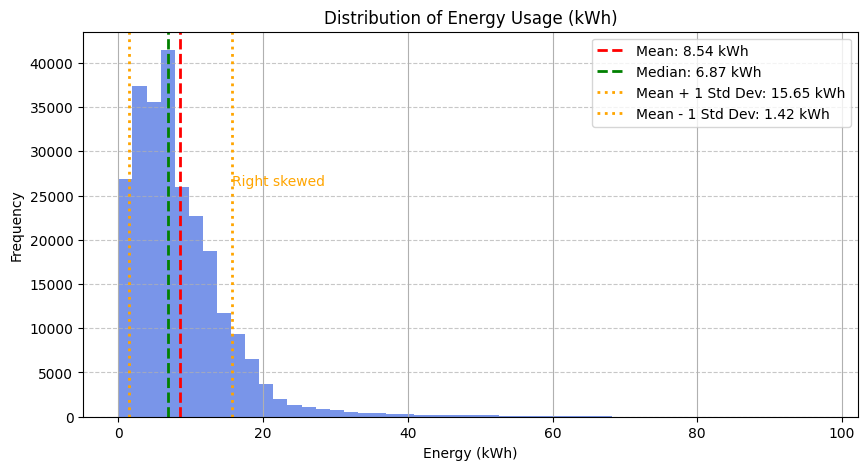

In [65]:
# Histogram for 'Energy (kWh)'

# Define the number of bins based on data range and spread
plt.figure(figsize=(10, 5))
energy_data = data['Energy (kWh)']

# Plot the histogram
energy_data.hist(bins=50, color='royalblue', alpha=0.7)
plt.title('Distribution of Energy Usage (kWh)')
plt.xlabel('Energy (kWh)')
plt.ylabel('Frequency')

# Add lines for statistical context
mean_energy = energy_data.mean()
median_energy = energy_data.median()
std_energy = energy_data.std()

# Plot lines for mean, median, and std deviation
plt.axvline(mean_energy, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_energy:.2f} kWh')
plt.axvline(median_energy, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_energy:.2f} kWh')
plt.axvline(mean_energy + std_energy, color='orange', linestyle='dotted', linewidth=2, label=f'Mean + 1 Std Dev: {(mean_energy + std_energy):.2f} kWh')
plt.axvline(mean_energy - std_energy, color='orange', linestyle='dotted', linewidth=2, label=f'Mean - 1 Std Dev: {(mean_energy - std_energy):.2f} kWh')

# Annotate the skewness
plt.text(mean_energy + std_energy, plt.ylim()[1] * 0.6, 'Right skewed', color='orange', fontsize=10)

# Add grid and legend
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()

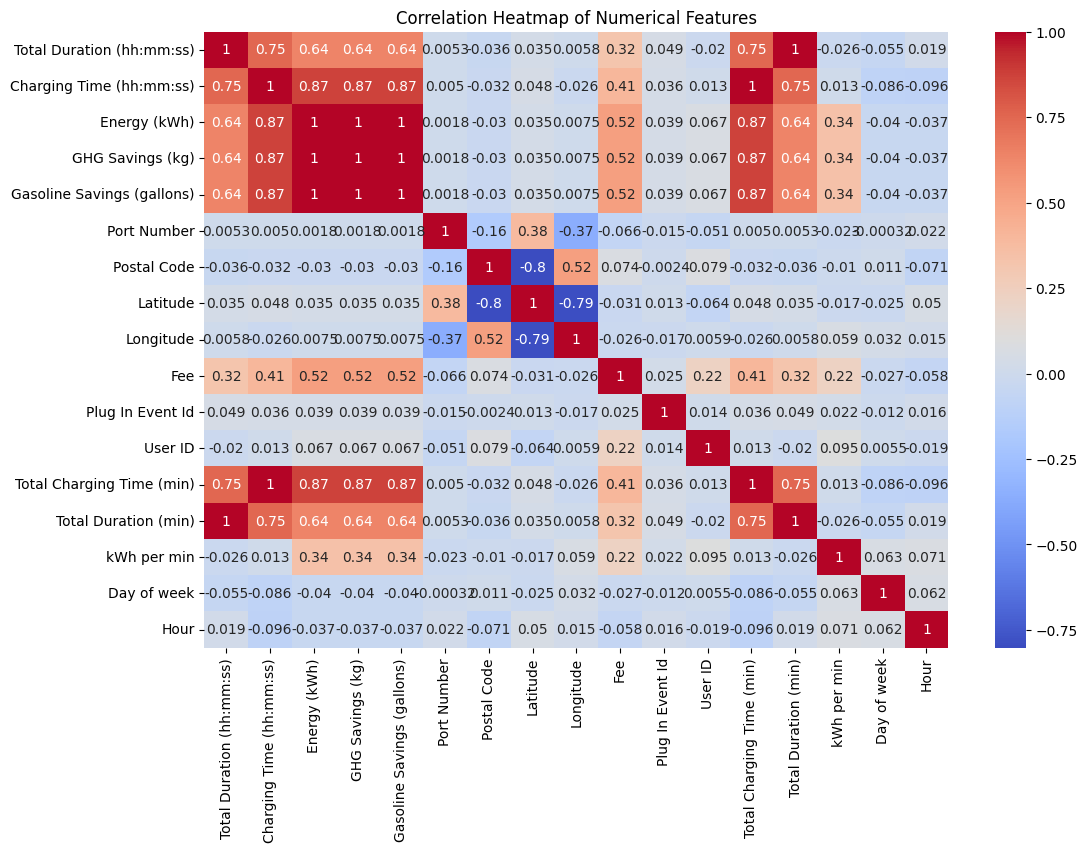

In [66]:
# Correlation Heatmap for numerical features
numerical_data = data.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

## **Mandatory Component**
---

### **1: Cluster**

### Clustering Analysis

In [67]:
# Clustering based on the new features
features_to_scale = usage_pivot.select_dtypes(include=[np.number])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_to_scale)

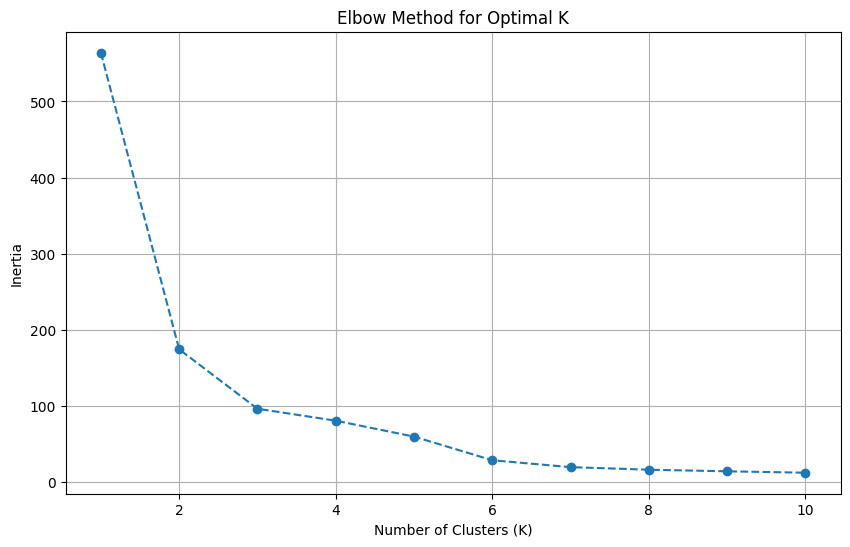

In [68]:
# Elbow Method for Determining Optimal K
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid()
plt.show()

In [69]:
# Apply KMeans Clustering
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

In [70]:
# Add cluster labels to the user usage pivot table
usage_pivot['Cluster'] = clusters

In [71]:
# Display clustered data
print("Clustered User Usage Patterns:")
usage_pivot

Clustered User Usage Patterns:


Charging Time (min)_Weekday_Day  \
Station Name                                                      
PALO ALTO CA / BRYANT # 1                          4.044800e+03   
PALO ALTO CA / BRYANT #1                           1.517255e+06   
PALO ALTO CA / BRYANT #2                           1.605358e+06   
PALO ALTO CA / BRYANT #3                           3.643064e+05   
PALO ALTO CA / BRYANT #4                           1.642677e+05   
PALO ALTO CA / BRYANT #5                           2.121966e+05   
PALO ALTO CA / BRYANT #6                           3.984481e+05   
PALO ALTO CA / CAMBRIDGE #1                        8.838196e+05   
PALO ALTO CA / CAMBRIDGE #2                        7.882662e+05   
PALO ALTO CA / CAMBRIDGE #3                        1.950987e+05   
PALO ALTO CA / CAMBRIDGE #4                        8.740368e+04   
PALO ALTO CA / CAMBRIDGE #5                        1.614629e+05   
PALO ALTO CA / HAMILTON #1                         1.595009e+06   
PALO ALTO CA / HAMILTON #2                         2.739938e+06   
PALO ALTO CA / HIGH #1                             7.403736e+05   
PALO ALTO CA / HIGH #2                             4.130390e+05   
PALO ALTO CA / HIGH #3                             4.910650e+05   
PALO ALTO CA / HIGH #4                             1.078427e+06   
PALO ALTO CA / MPL #1                              2.043305e+05   
PALO ALTO CA / MPL #2                              3.381223e+05   
PALO ALTO CA / MPL #3                              3.402715e+05   
PALO ALTO CA / MPL #4                              9.356162e+05   
PALO ALTO CA / MPL #5                              7.492402e+05   
PALO ALTO CA / MPL #6                              9.366152e+05   
PALO ALTO CA / RINCONADA LIB 1                     7.656309e+05   
PALO ALTO CA / RINCONADA LIB 2                     7.171420e+05   
PALO ALTO CA / RINCONADA LIB 3                     7.263815e+05   
PALO ALTO CA / SHERMAN 1                           7.316000e+02   
PALO ALTO CA / SHERMAN 11                          5.900000e+01   
PALO ALTO CA / SHERMAN 14                          0.000000e+00   
PALO ALTO CA / SHERMAN 15                          0.000000e+00   
PALO ALTO CA / SHERMAN 17                          5.700000e+01   
PALO ALTO CA / SHERMAN 2                           0.000000e+00   
PALO ALTO CA / SHERMAN 3                           8.400000e+01   
PALO ALTO CA / SHERMAN 4                           0.000000e+00   
PALO ALTO CA / SHERMAN 5                           0.000000e+00   
PALO ALTO CA / SHERMAN 6                           0.000000e+00   
PALO ALTO CA / SHERMAN 7                           1.300000e+01   
PALO ALTO CA / SHERMAN 8                           0.000000e+00   
PALO ALTO CA / SHERMAN 9                           0.000000e+00   
PALO ALTO CA / TED THOMPSON #1                     1.116755e+06   
PALO ALTO CA / TED THOMPSON #2                     2.258655e+05   
PALO ALTO CA / TED THOMPSON #3                     1.585520e+05   
PALO ALTO CA / TED THOMPSON #4                     1.191680e+05   
PALO ALTO CA / WEBSTER #1                          1.691920e+06   
PALO ALTO CA / WEBSTER #2                          1.537489e+06   
PALO ALTO CA / WEBSTER #3                          9.263670e+05   

                                Charging Time (min)_Weekday_Night  \
Station Name                                                        
PALO ALTO CA / BRYANT # 1                            5.270067e+03   
PALO ALTO CA / BRYANT #1                             2.480607e+06   
PALO ALTO CA / BRYANT #2                             2.585631e+06   
PALO ALTO CA / BRYANT #3                             8.615624e+05   
PALO ALTO CA / BRYANT #4                             8.307107e+05   
PALO ALTO CA / BRYANT #5                             1.069603e+06   
PALO ALTO CA / BRYANT #6                             1.213480e+06   
PALO ALTO CA / CAMBRIDGE #1                          1.833093e+06   
PALO ALTO CA / CAMBRIDGE #2                          1.694

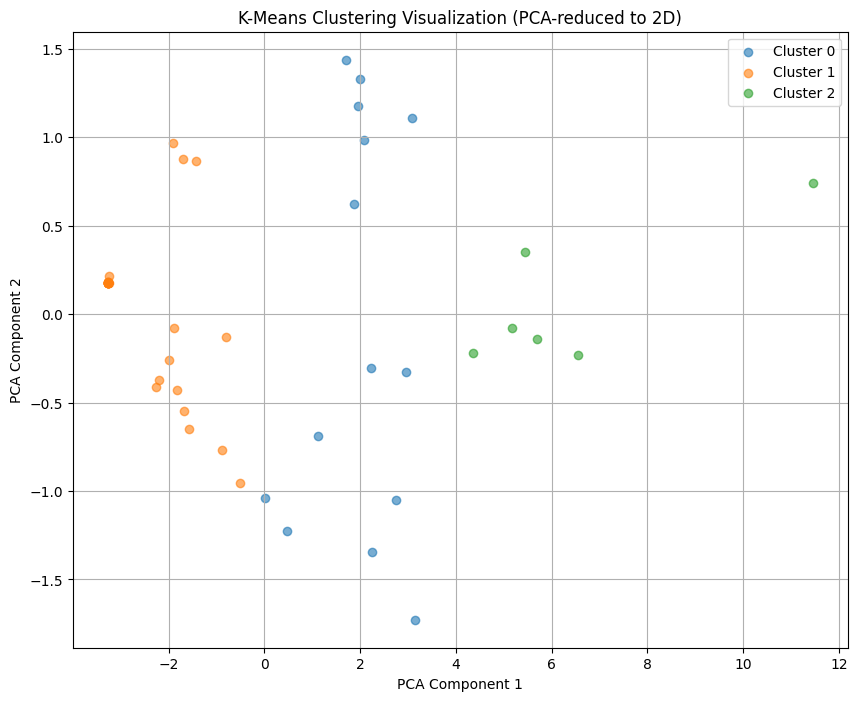

In [72]:
# Plot cluster visualization using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 8))
for cluster in range(optimal_k):
    cluster_points = reduced_data[usage_pivot['Cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', alpha=0.6)

plt.title('K-Means Clustering Visualization (PCA-reduced to 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

### Evaluating and Visualizing Clusters

In [73]:
# Silhouette Score for Evaluating Clustering Quality
silhouette_avg = silhouette_score(scaled_features, clusters)
print(f"Silhouette Score for K={optimal_k}: {silhouette_avg}")

Silhouette Score for K=3: 0.5971669793384567


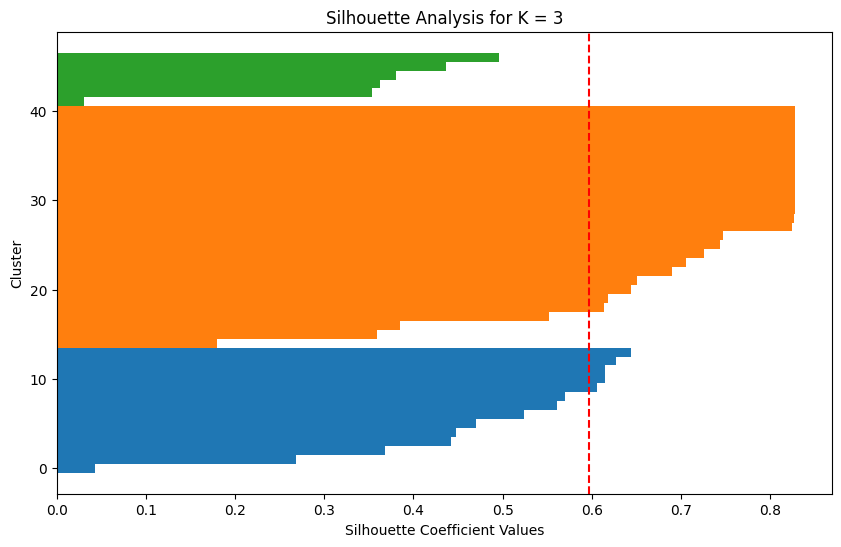

In [74]:
silhouette_vals = silhouette_samples(scaled_features, clusters)
plt.figure(figsize=(10, 6))
y_lower, y_upper = 0, 0
for i in range(optimal_k):
    cluster_silhouette_vals = silhouette_vals[clusters == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
    y_lower += len(cluster_silhouette_vals)

plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.title(f"Silhouette Analysis for K = {optimal_k}")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster")
plt.show()

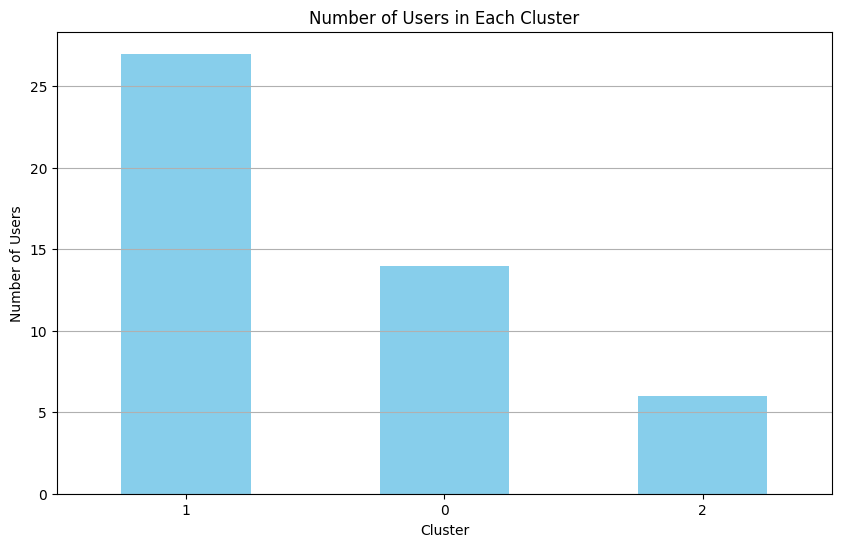

In [75]:
# Plot: Cluster Size Distribution
cluster_counts = usage_pivot['Cluster'].value_counts()

plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Users in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

### Understanding the Clusters

<Figure size 1400x800 with 0 Axes>

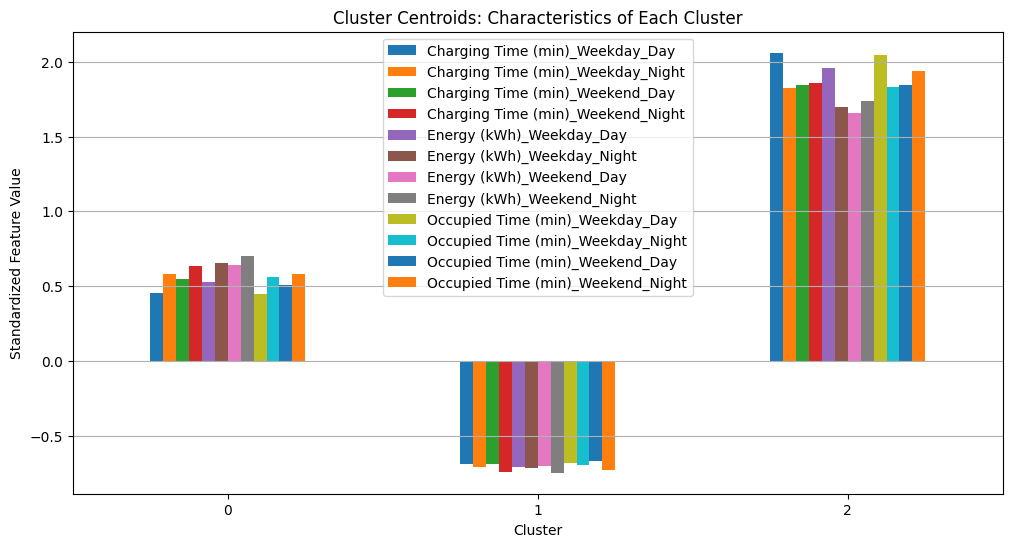

In [76]:
# Plot: Cluster Centroid Characteristics
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns=features_to_scale.columns)

plt.figure(figsize=(14, 8))
centroid_df.plot(kind='bar', figsize=(12, 6))
plt.title('Cluster Centroids: Characteristics of Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Standardized Feature Value')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [77]:
centroid_variances = centroid_df.var(axis=0)
important_features = centroid_variances.sort_values(ascending=False)
print("Most important features driving cluster differences:")
print(important_features)

Most important features driving cluster differences:
Charging Time (min)_Weekday_Day      1.913996
Occupied Time (min)_Weekday_Day      1.880371
Energy (kWh)_Weekday_Day             1.785213
Occupied Time (min)_Weekend_Night    1.776254
Charging Time (min)_Weekend_Night    1.696400
Charging Time (min)_Weekend_Day      1.611478
Occupied Time (min)_Weekday_Night    1.605158
Charging Time (min)_Weekday_Night    1.601493
Occupied Time (min)_Weekend_Day      1.582733
Energy (kWh)_Weekend_Night           1.561490
Energy (kWh)_Weekday_Night           1.461784
Energy (kWh)_Weekend_Day             1.402950
dtype: float64


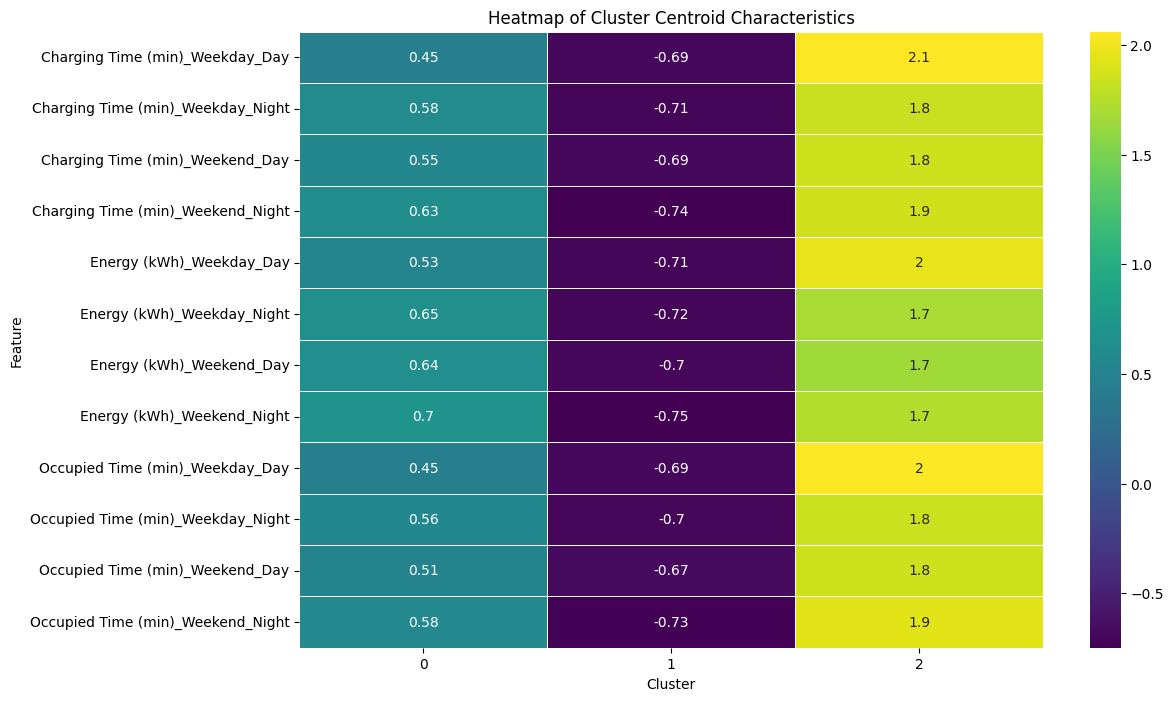

In [78]:
plt.figure(figsize=(12, 8))
sns.heatmap(centroid_df.T, annot=True, cmap='viridis', linewidths=0.5)
plt.title('Heatmap of Cluster Centroid Characteristics')
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.show()

### Cluster Interpretation

In [79]:
# Cluster Interpretation
cluster_descriptions = []

# Print available columns to check for correct names
print("Available columns in centroid_df:", centroid_df.columns)

for idx, centroid in centroid_df.iterrows():
    # Adjust the column names here based on actual names in centroid_df
    if 'Energy (kWh)' in centroid_df.columns:
        if centroid['Energy (kWh)'] > 1.0:
            energy_desc = "high energy usage"
        else:
            energy_desc = "low energy usage"
    else:
        energy_desc = "unknown energy usage"

    if 'Charging Time (min)' in centroid_df.columns:
        if centroid['Charging Time (min)'] > 60:
            charge_desc = "long charging durations"
        else:
            charge_desc = "short charging durations"
    else:
        charge_desc = "unknown charging durations"

    if 'Weekend/Weekday_Weekend' in centroid_df.columns and 'Weekend/Weekday_Weekday' in centroid_df.columns:
        if centroid['Weekend/Weekday_Weekend'] > centroid['Weekend/Weekday_Weekday']:
            time_desc = "prefers charging on weekends"
        else:
            time_desc = "prefers charging on weekdays"
    else:
        time_desc = "unknown charging preference"
        
    cluster_description = f"Cluster {idx}: {energy_desc}, {charge_desc}, and {time_desc}."
    cluster_descriptions.append(cluster_description)
    print(cluster_description)

Available columns in centroid_df: Index(['Charging Time (min)_Weekday_Day', 'Charging Time (min)_Weekday_Night',
       'Charging Time (min)_Weekend_Day', 'Charging Time (min)_Weekend_Night',
       'Energy (kWh)_Weekday_Day', 'Energy (kWh)_Weekday_Night',
       'Energy (kWh)_Weekend_Day', 'Energy (kWh)_Weekend_Night',
       'Occupied Time (min)_Weekday_Day', 'Occupied Time (min)_Weekday_Night',
       'Occupied Time (min)_Weekend_Day', 'Occupied Time (min)_Weekend_Night'],
      dtype='object')
Cluster 0: unknown energy usage, unknown charging durations, and unknown charging preference.
Cluster 1: unknown energy usage, unknown charging durations, and unknown charging preference.
Cluster 2: unknown energy usage, unknown charging durations, and unknown charging preference.


In [80]:
# Actionable Recommendations
print("\nRecommendations:")
for idx, description in enumerate(cluster_descriptions):
    if "high energy usage" in description and "long charging durations" in description:
        recommendation = f"Cluster {idx}: Consider offering discounts or incentives for charging during off-peak hours to balance grid load."
    elif "low energy usage" in description and "prefers charging on weekends" in description:
        recommendation = f"Cluster {idx}: Provide weekend promotional offers to increase station utilization."
    else:
        recommendation = f"Cluster {idx}: Monitor charging behavior and offer personalized suggestions to improve station usage."
    print(recommendation)


Recommendations:
Cluster 0: Monitor charging behavior and offer personalized suggestions to improve station usage.
Cluster 1: Monitor charging behavior and offer personalized suggestions to improve station usage.
Cluster 2: Monitor charging behavior and offer personalized suggestions to improve station usage.


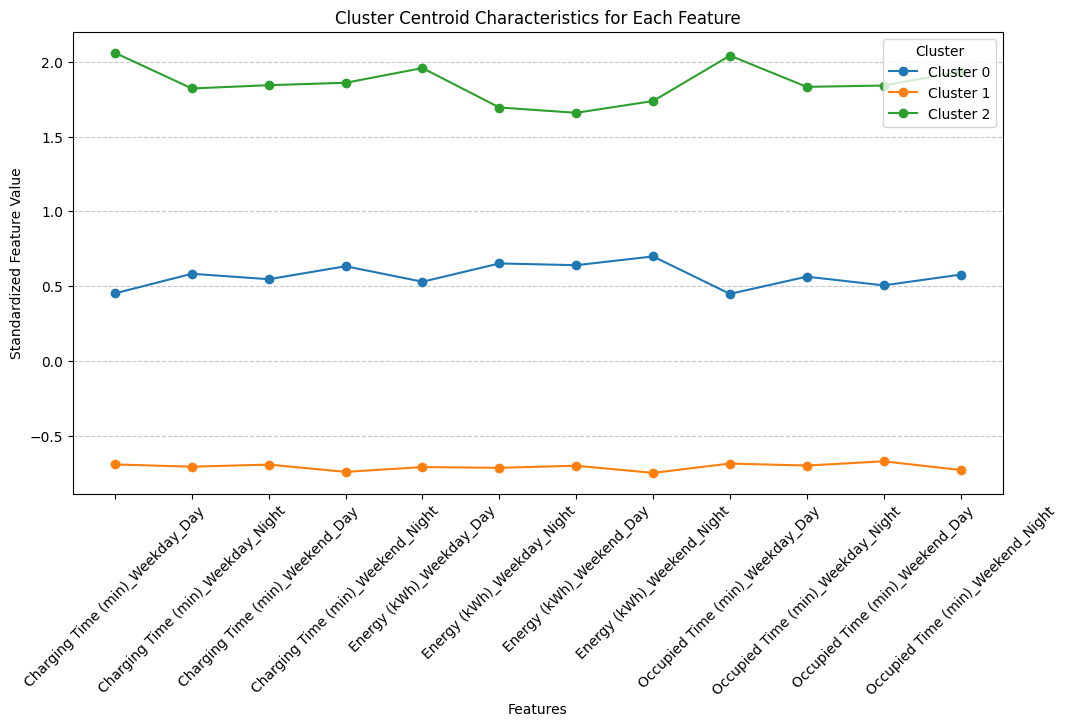

In [81]:
plt.figure(figsize=(12, 6))
for idx in range(optimal_k):
    plt.plot(centroid_df.columns, centroid_df.iloc[idx], marker='o', label=f'Cluster {idx}')

plt.title('Cluster Centroid Characteristics for Each Feature')
plt.xlabel('Features')
plt.ylabel('Standardized Feature Value')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

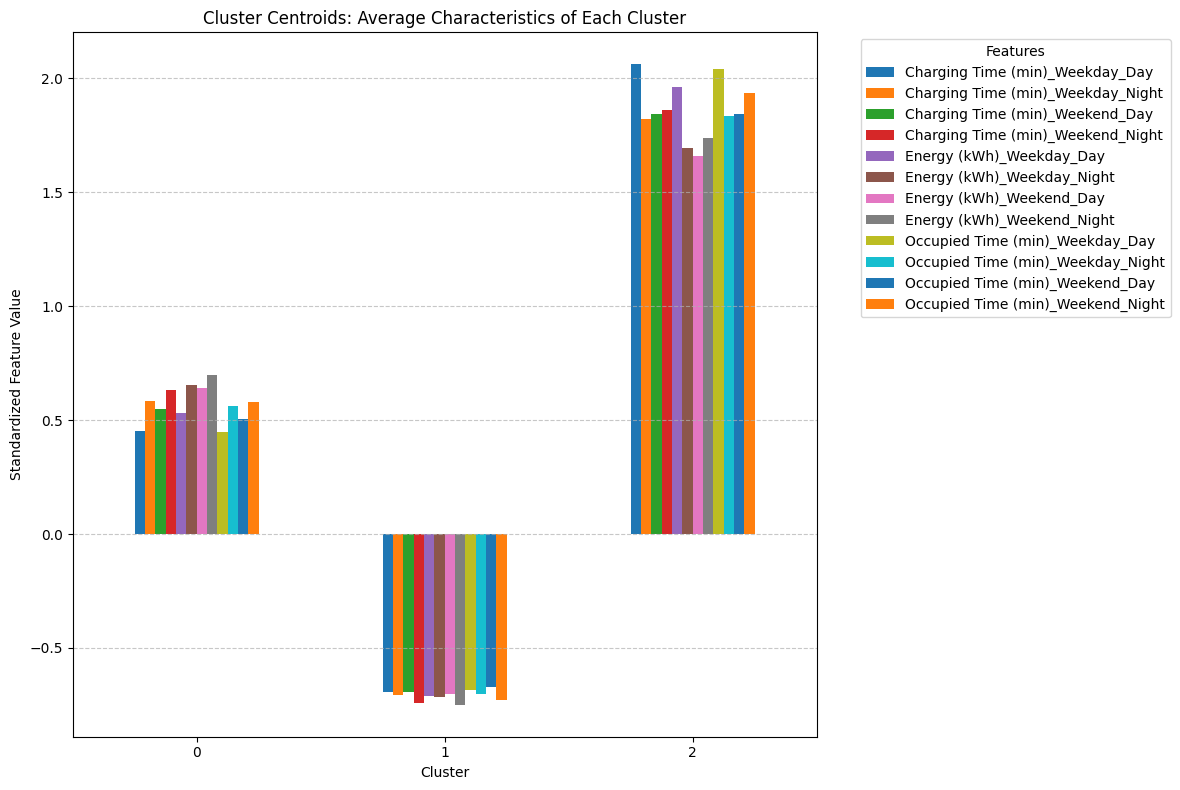

In [82]:
# Plotting cluster centroids using bar charts
centroid_df.plot(kind='bar', figsize=(12, 8))
plt.title('Cluster Centroids: Average Characteristics of Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Standardized Feature Value')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### **2: Prediction model**

In [83]:
d = data.set_index('Start Date')

In [84]:
# Feature Engineering
data['Date'] = data['Start Date'].dt.date
data['Hour'] = data['Start Date'].dt.hour
station_hourly = data[['Date', 'Station Name', 'Hour', 'Energy (kWh)']]

pivoted = station_hourly.pivot_table(
    index=['Date', 'Station Name'],
    columns='Hour',
    values='Energy (kWh)',
    aggfunc='sum',
    fill_value=0
).reset_index()

pivoted.columns = [f'Hour_{int(col)}' if isinstance(col, int) else col for col in pivoted.columns]
pivoted.sort_values(['Date', 'Station Name'], inplace=True)

In [85]:
station_hourly

Date                    Station Name  Hour  Energy (kWh)
0       2011-07-29      PALO ALTO CA / HAMILTON #1    20      6.249457
1       2011-07-30      PALO ALTO CA / HAMILTON #1     0      0.106588
2       2011-07-30      PALO ALTO CA / HAMILTON #1     8     14.951777
3       2011-07-30      PALO ALTO CA / HAMILTON #1    14      7.159643
4       2011-07-30      PALO ALTO CA / HAMILTON #1    18      1.957765
...            ...                             ...   ...           ...
259410  2020-12-31  PALO ALTO CA / TED THOMPSON #3    16      1.841000
259411  2020-12-31       PALO ALTO CA / WEBSTER #1    16     12.744000
259412  2020-12-31           PALO ALTO CA / MPL #4    17     29.665000
259413  2020-12-31       PALO ALTO CA / WEBSTER #1    17     11.976000
259414  2020-12-31     PALO ALTO CA / CAMBRIDGE #4    18      1.571000

[249879 rows x 4 columns]

In [86]:
pivoted

Date                    Station Name    Hour_0  Hour_1  Hour_2  \
0      2011-07-29      PALO ALTO CA / HAMILTON #1  0.000000     0.0     0.0   
1      2011-07-30      PALO ALTO CA / HAMILTON #1  0.106588     0.0     0.0   
2      2011-07-31      PALO ALTO CA / HAMILTON #1  0.000000     0.0     0.0   
3      2011-08-01      PALO ALTO CA / HAMILTON #1  0.000000     0.0     0.0   
4      2011-08-02      PALO ALTO CA / HAMILTON #1  0.000000     0.0     0.0   
...           ...                             ...       ...     ...     ...   
55028  2020-12-31        PALO ALTO CA / SHERMAN 6  0.000000     0.0     0.0   
55029  2020-12-31  PALO ALTO CA / TED THOMPSON #3  0.000000     0.0     0.0   
55030  2020-12-31  PALO ALTO CA / TED THOMPSON #4  0.000000     0.0     0.0   
55031  2020-12-31       PALO ALTO CA / WEBSTER #1  0.000000     0.0     0.0   
55032  2020-12-31       PALO ALTO CA / WEBSTER #3  0.000000     0.0     0.0   

       Hour_3     Hour_4  Hour_5  Hour_6  Hour_7  ...   Hour_14  Hour_15  \
0         0.0   0.000000     0.0     0.0     0.0  ...  0.000000      0.0   
1         0.0   0.000000     0.0     0.0     0.0  ...  7.159643      0.0   
2         0.0  17.171463     0.0     0.0     0.0  ...  0.000000      0.0   
3         0.0   0.000000     0.0     0.0     0.0  ...  0.000000      0.0   
4         0.0   0.000000     0.0     0.0     0.0  ...  4.197217      0.0   
...       ...        ...     ...     ...     ...  ...       ...      ...   
55028     0.0   0.000000     0.0     0.0     0.0  ...  0.000000      0.0   
55029     0.0   0.000000     0.0     0.0     0.0  ...  0.000000      0.0   
55030     0.0   0.000000     0.0     0.0     0.0  ...  0.000000      0.0   
55031     0.0   0.000000     0.0     0.0     0.0  ...  0.000000      0.0   
55032     0.0   0.000000     0.0     0.0     0.0  ...  7.075000      0.0   

       Hour_16    Hour_17   Hour_18   Hour_19   Hour_20  Hour_21  Hour_22  \
0        0.000   0.000000  0.000000  0.000000  6.249457      0.0      0.0   
1        0.000   0.000000  1.957765  0.000000  0.000000      0.0      0.0   
2        0.000  16.238552  0.000000  0.000000  0.000000      0.0      0.0   
3        0.000   0.000000  0.000000  5.041244  0.000000      0.0      0.0   
4        0.000   0.000000  0.000000  0.000000  0.000000      0.0      0.0   
...        ...        ...       ...       ...       ...      ...      ...   
55028    0.000   0.000000  0.000000  0.000000  0.000000      0.0      0.0   
55029    1.841   0.000000  0.000000  0.000000  0.000000      0.0      0.0   
55030    0.000   0.000000  0.000000  0.000000  0.000000      0.0      0.0   
55031   12.744  11.976000  0.000000  0.000000  0.000000      0.0      0.0   
55032    0.000   0.000000  0.000000  0.000000  0.000000      0.0      0.0   

       Hour_23  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  
...        ...  
55028      0.0  
55029      0.0  
55030      0.0  
55031      0.0  
55032      0.0  

[55033 rows x 26 columns]

In [87]:
# Calculate historical average for each hour across all previous days
for hour in range(24):
    col_name = f'Hour_{hour}'
    pivoted[f'{col_name}_historical_avg'] = pivoted.groupby('Station Name')[col_name].transform(lambda x: x.expanding().mean().shift(1))

pivoted.dropna(inplace=True)

**Features (X) and Targets (y):**

In [88]:
X_features = [f'Hour_{hour}_historical_avg' for hour in range(24)]
y_targets = [f'Hour_{hour}' for hour in range(24)]

**Train-Test Split**

In [89]:
# Use 70% of the data for training and 30% for testing
split_index = int(0.7 * len(pivoted))
train_pivot = pivoted.iloc[:split_index]
test_pivot = pivoted.iloc[split_index:]

print(f"Training Set Size (70%): {len(train_pivot)}")
print(f"Test Set Size (30%): {len(test_pivot)}")

Training Set Size (70%): 38490
Test Set Size (30%): 16496


In [90]:
# **Split Training Set into Train and Validation Subset (Within 70%)**
split_index_validation_train = int(0.8 * len(train_pivot))
train_pivot_final = train_pivot.iloc[:split_index_validation_train]
validation_pivot_train = train_pivot.iloc[split_index_validation_train:]

print(f"Training Set Size after splitting (56% of total): {len(train_pivot_final)}")
print(f"Validation Set Size within Training (14% of total): {len(validation_pivot_train)}")

Training Set Size after splitting (56% of total): 30792
Validation Set Size within Training (14% of total): 7698


In [91]:
# **Split Test Set into Test and Validation Subset (Within 30%)**
split_index_validation_test = int(0.5 * len(test_pivot))
validation_pivot_test = test_pivot.iloc[:split_index_validation_test]
test_pivot_final = test_pivot.iloc[split_index_validation_test:]

print(f"Validation Set Size within Test (15% of total): {len(validation_pivot_test)}")
print(f"Final Test Set Size (15% of total): {len(test_pivot_final)}")

Validation Set Size within Test (15% of total): 8248
Final Test Set Size (15% of total): 8248


### **Baseline Model for Prediction**

In [92]:
X_train = train_pivot_final[X_features].values
y_train = train_pivot_final[y_targets].values
X_validation_train = validation_pivot_train[X_features].values
y_validation_train = validation_pivot_train[y_targets].values
X_validation_test = validation_pivot_test[X_features].values
y_validation_test = validation_pivot_test[y_targets].values
X_test = test_pivot_final[X_features].values
y_test = test_pivot_final[y_targets].values

**Train a Machine Learning Model**

In [93]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_validation_train = model.predict(X_validation_train)

mse_validation_train = mean_squared_error(y_validation_train, y_pred_validation_train)
mae_validation_train = mean_absolute_error(y_validation_train, y_pred_validation_train)
print(f"Validation within Training Set - MSE: {mse_validation_train:.2f}, MAE: {mae_validation_train:.2f}")

Validation within Training Set - MSE: 19.17, MAE: 2.38


**Evalate the model**

In [94]:
y_pred_validation_test = model.predict(X_validation_test)
mse_validation_test = mean_squared_error(y_validation_test, y_pred_validation_test)
mae_validation_test = mean_absolute_error(y_validation_test, y_pred_validation_test)
print(f"Validation within Test Set - MSE: {mse_validation_test:.2f}, MAE: {mae_validation_test:.2f}")

Validation within Test Set - MSE: 23.52, MAE: 2.53


- The MSE (Mean Squared Error) represents the average squared difference between the predicted and actual values, and the MAE (Mean Absolute Error) is the average absolute difference.
- The Validation MSE and MAE are slightly lower than the Test MSE and MAE. This suggests that the model is generalizing reasonably well to unseen data, but there is a slight increase in error when moving to the final test set, which is expected in most cases.
- The difference between the validation and test errors is not too large, which means your model is likely not overfitting significantly, and it is performing reasonably well given the baseline you have established.

**Final Test Evaluation**

In [95]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Linear Regression Model - Final Test Set - MSE: {mse:.2f}, MAE: {mae:.2f}")

Linear Regression Model - Final Test Set - MSE: 21.04, MAE: 2.40


## **Advanced Prediction Model**

### Random Forrest - ensemble model

In [96]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf_validation_test = rf_model.predict(X_validation_test)

mse_rf_validation_test = mean_squared_error(y_validation_test, y_pred_rf_validation_test)
mae_rf_validation_test = mean_absolute_error(y_validation_test, y_pred_rf_validation_test)
print(f"Random Forest Model - Validation within Test Set - MSE: {mse_rf_validation_test:.2f}, MAE: {mae_rf_validation_test:.2f}")

Random Forest Model - Validation within Test Set - MSE: 26.53, MAE: 2.97


In [48]:
# Instantiate and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict using the validation set within the training set
y_pred_validation_rf = rf_model.predict(X_validation_train)

# Calculate metrics on validation set within training
mse_validation_rf = mean_squared_error(y_validation_train, y_pred_validation_rf)
mae_validation_rf = mean_absolute_error(y_validation_train, y_pred_validation_rf)

print(f"Random Forest Model - Validation within Training Set - MSE: {mse_validation_rf:.2f}, MAE: {mae_validation_rf:.2f}")

Random Forest Model - Validation within Training Set - MSE: 23.08, MAE: 2.68


In [49]:
y_pred_rf_test = rf_model.predict(X_test)
mse_rf_test = mean_squared_error(y_test, y_pred_rf_test)
mae_rf_test = mean_absolute_error(y_test, y_pred_rf_test)
print(f"Random Forest Model - Test Set - MSE: {mse_rf_test:.2f}, MAE: {mae_rf_test:.2f}")

Random Forest Model - Test Set - MSE: 24.70, MAE: 2.97


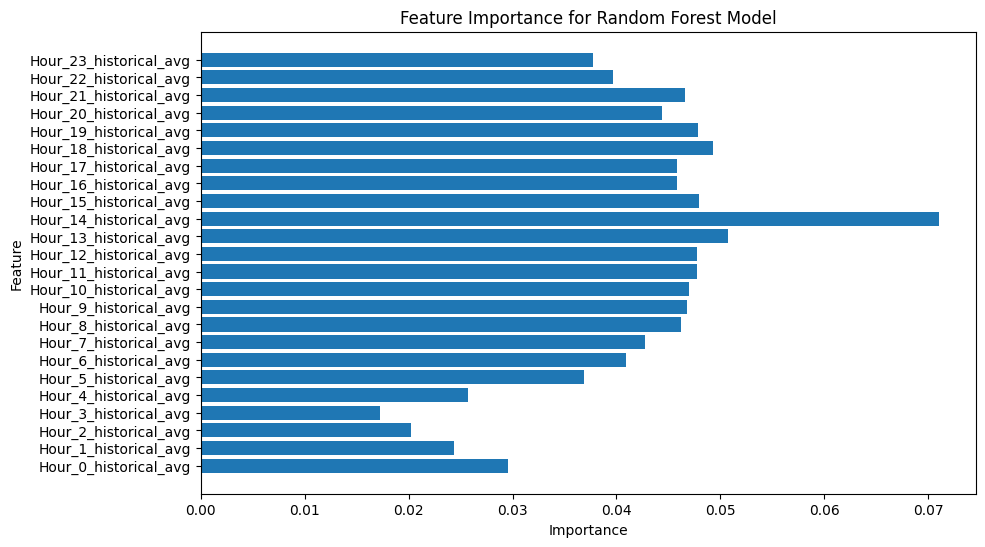

In [106]:
feature_importances = rf_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X_features, feature_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.show()

> Plot a feature importance graph for the Random Forest model to highlight which historical averages have the most predictive power.

### Neural Network Model

In [50]:
# Build Neural Network model
nn_model = Sequential()
nn_model.add(Dense(128, input_dim=len(X_features), activation='relu'))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dense(24))  # Output layer for each hour

# Compile the model
nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model on training data
nn_model.fit(X_train, y_train, validation_data=(X_validation_train, y_validation_train), epochs=50, batch_size=32, verbose=2)

Epoch 1/50
963/963 - 1s - 874us/step - loss: 21.0004 - mae: 2.4914 - val_loss: 19.2892 - val_mae: 2.4199
Epoch 2/50
963/963 - 0s - 385us/step - loss: 20.7953 - mae: 2.4864 - val_loss: 19.0039 - val_mae: 2.3023
Epoch 3/50
963/963 - 0s - 395us/step - loss: 20.7342 - mae: 2.4796 - val_loss: 18.9541 - val_mae: 2.2548
Epoch 4/50
963/963 - 0s - 394us/step - loss: 20.6878 - mae: 2.4734 - val_loss: 18.9339 - val_mae: 2.2043
Epoch 5/50
963/963 - 0s - 400us/step - loss: 20.6503 - mae: 2.4697 - val_loss: 18.9344 - val_mae: 2.1019
Epoch 6/50
963/963 - 0s - 412us/step - loss: 20.6245 - mae: 2.4648 - val_loss: 18.9676 - val_mae: 2.2638
Epoch 7/50
963/963 - 0s - 386us/step - loss: 20.6084 - mae: 2.4626 - val_loss: 18.9046 - val_mae: 2.1926
Epoch 8/50
963/963 - 0s - 381us/step - loss: 20.5817 - mae: 2.4587 - val_loss: 18.8365 - val_mae: 2.2027
Epoch 9/50
963/963 - 0s - 380us/step - loss: 20.5730 - mae: 2.4587 - val_loss: 18.9220 - val_mae: 2.1110
Epoch 10/50
963/963 - 0s - 380us/step - loss: 20.5566 -

In [51]:
# Predict using the neural network model on test set
y_pred_nn_test = nn_model.predict(X_test)

# Calculate metrics for evaluation
mse_nn_test = mean_squared_error(y_test, y_pred_nn_test)
mae_nn_test = mean_absolute_error(y_test, y_pred_nn_test)

print(f"Neural Network Model - Test Set - MSE: {mse_nn_test:.2f}, MAE: {mae_nn_test:.2f}")

258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
Neural Network Model - Test Set - MSE: 20.84, MAE: 2.17


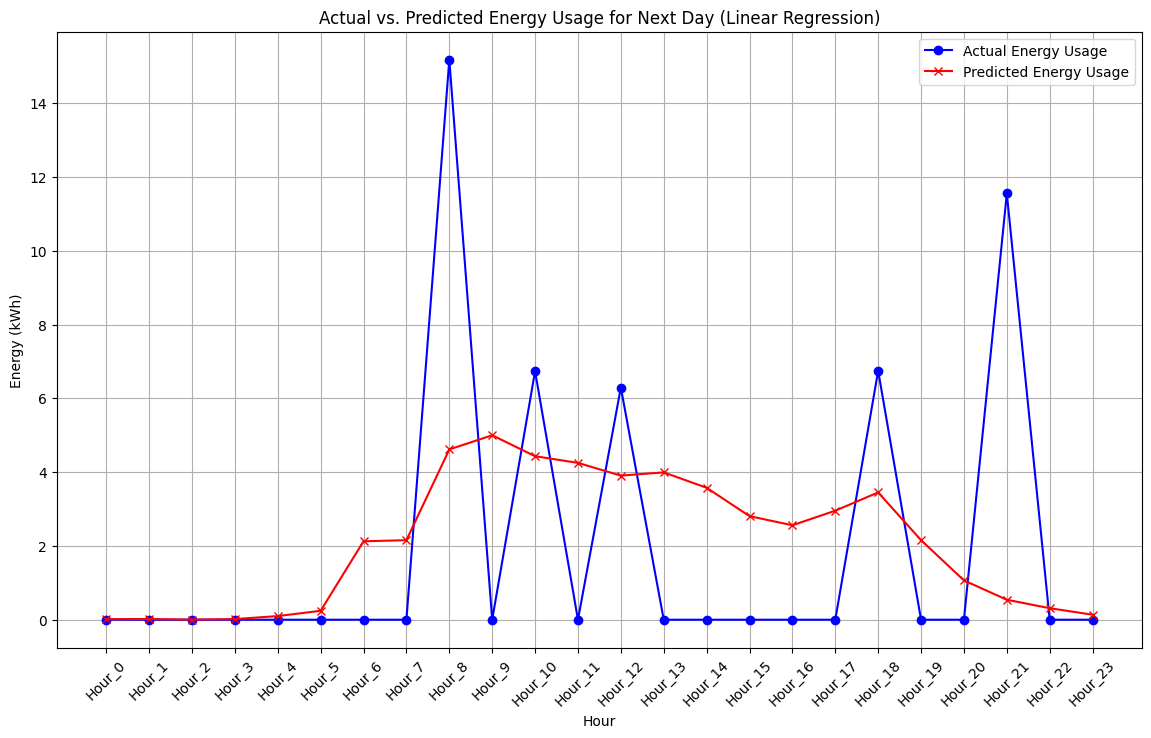

In [ ]:
plt.figure(figsize=(14, 8))
hours = [f'Hour_{i}' for i in range(24)]
plt.plot(hours, y_test[0], label='Actual Energy Usage', marker='o', color='blue')
plt.plot(hours, y_pred[0], label='Predicted Energy Usage', marker='x', color='red')
plt.xlabel('Hour')
plt.ylabel('Energy (kWh)')
plt.title('Actual vs. Predicted Energy Usage for Next Day (Linear Regression)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

> Visualize Predictions vs. Actuals

> Pick a specific charging station and visualize the predicted versus actual energy usage for each hour to understand the model’s performance visually.

In [109]:
# Calculate MSEs for the models
model_mses = {
    'Linear Regression': mse,
    'Random Forest': mse_rf_test,
    'Neural Network': mse_nn_test
}

# Select the model with the lowest MSE
best_model_name = min(model_mses, key=model_mses.get)
best_model_mse = model_mses[best_model_name]

print(f"\n--- Best Model Selection ---")
print(f"The best model is: {best_model_name} with MSE: {best_model_mse:.2f}")

# Optional: Use MAE if you want another perspective
model_maes = {
    'Linear Regression': mae,
    'Random Forest': mae_rf_test,
    'Neural Network': mae_nn_test
}

best_model_name_mae = min(model_maes, key=model_maes.get)
best_model_mae = model_maes[best_model_name_mae]

print(f"The best model by MAE is: {best_model_name_mae} with MAE: {best_model_mae:.2f}")


--- Best Model Selection ---
The best model is: Neural Network with MSE: 20.84
The best model by MAE is: Neural Network with MAE: 2.17


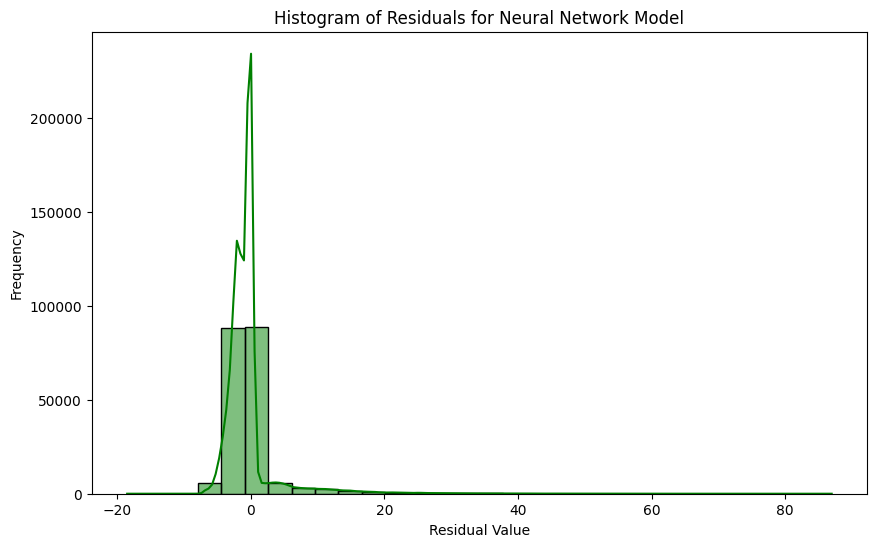

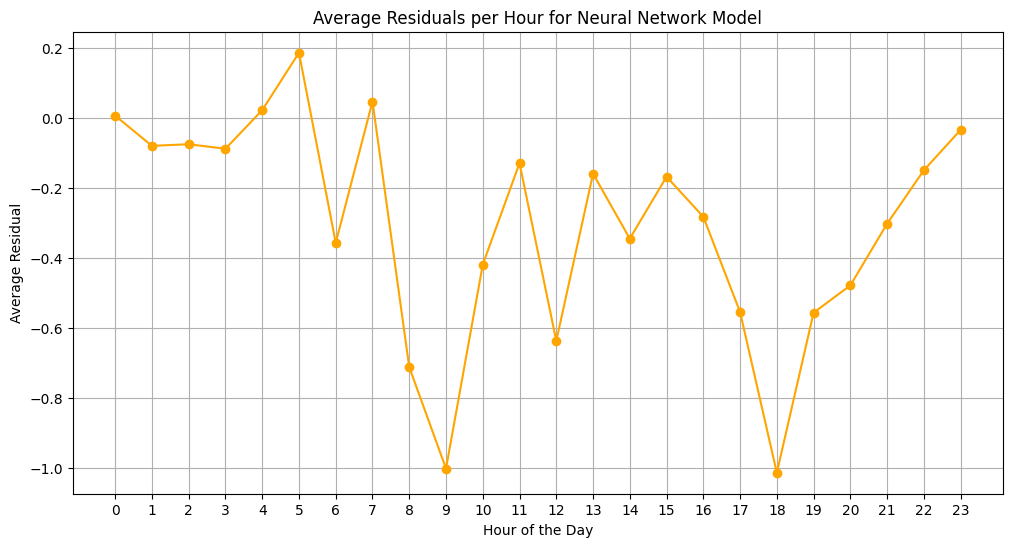

Hours with High Average Residuals for Neural Network Model:
Hour_6    -0.356495
Hour_8    -0.711391
Hour_9    -1.000792
Hour_10   -0.418709
Hour_12   -0.636496
Hour_14   -0.344657
Hour_17   -0.554083
Hour_18   -1.012628
Hour_19   -0.555940
Hour_20   -0.478006
dtype: float64
Days with High Residuals for Neural Network Model:
            Date                    Station Name  Total Residual
1     2019-11-19          PALO ALTO CA / HIGH #2       91.884485
2     2019-11-19          PALO ALTO CA / HIGH #3       90.706613
3     2019-11-19          PALO ALTO CA / HIGH #4       81.201409
11    2019-11-19  PALO ALTO CA / TED THOMPSON #2       84.983160
14    2019-11-19       PALO ALTO CA / WEBSTER #1      138.114155
...          ...                             ...             ...
8120  2020-12-22  PALO ALTO CA / TED THOMPSON #3       75.157755
8126  2020-12-23        PALO ALTO CA / BRYANT #6      106.110456
8145  2020-12-24          PALO ALTO CA / HIGH #1       83.734931
8199  2020-12-28  PALO A

In [111]:
# **Residual Analysis for Neural Network Model**

# Calculate residuals for the Neural Network Model
residuals_nn = y_test - y_pred_nn_test

# Flatten residuals for histogram
residuals_nn_flat = residuals_nn.flatten()

# Plot histogram of residuals for Neural Network
plt.figure(figsize=(10, 6))
sns.histplot(residuals_nn_flat, bins=30, kde=True, color='green')
plt.title('Histogram of Residuals for Neural Network Model')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()

# Identify periods where the Neural Network model is performing poorly (specific hours or days)
residuals_nn_df = pd.DataFrame(residuals_nn, columns=y_targets)
residuals_nn_df['Date'] = test_pivot_final['Date'].values
residuals_nn_df['Station Name'] = test_pivot_final['Station Name'].values

# Calculate the average residual per hour for the Neural Network model
average_residuals_nn_per_hour = residuals_nn_df[y_targets].mean()

# Plot average residuals per hour for Neural Network Model
plt.figure(figsize=(12, 6))
plt.plot(range(24), average_residuals_nn_per_hour, marker='o', linestyle='-', color='orange')
plt.xticks(range(24))
plt.title('Average Residuals per Hour for Neural Network Model')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Residual')
plt.grid()
plt.show()

# Print out hours with high average residuals (indicating poor performance)
poor_performance_hours_nn = average_residuals_nn_per_hour[average_residuals_nn_per_hour.abs() > average_residuals_nn_per_hour.std()]
print("Hours with High Average Residuals for Neural Network Model:")
print(poor_performance_hours_nn)

# Identify days with high residuals for Neural Network Model
residuals_nn_df['Total Residual'] = residuals_nn_df[y_targets].abs().sum(axis=1)
high_residual_days_nn = residuals_nn_df[residuals_nn_df['Total Residual'] > residuals_nn_df['Total Residual'].mean() + residuals_nn_df['Total Residual'].std()]
print("Days with High Residuals for Neural Network Model:")
print(high_residual_days_nn[['Date', 'Station Name', 'Total Residual']])


## **Exploratory Component**
---

In [97]:
# Check if 'Model Number' exists in the DataFrame
if 'Model Number' not in data.columns:
    print("The 'Model Number' column is missing. Adding it with default values.")
    # Add the 'Model Number' column with a default value of 'Unknown'
    data['Model Number'] = 'Unknown'

# If 'Model Number' exists, handle missing values
data['Model Number'] = data['Model Number'].fillna('Unknown')

# Verify that the column has been restored and no missing values remain
print(data['Model Number'].isnull().sum())  # Should print 0
print(data['Model Number'].head())  # Show the first few values for verification

The 'Model Number' column is missing. Adding it with default values.
0
0    Unknown
1    Unknown
2    Unknown
3    Unknown
4    Unknown
Name: Model Number, dtype: object


In [98]:
# Data Cleaning: Handling missing values
# Fill missing 'Port Type' with the most frequent value
data['Port Type'] = data['Port Type'].fillna(data['Port Type'].mode()[0])
print("Filled missing values for 'Port Type'.")

# Replace missing 'Model Number' with 'Unknown'
data['Model Number'] = data['Model Number'].fillna('Unknown')
print("Replaced missing 'Model Number' with 'Unknown'.")

# Drop rows with missing 'User ID'
data = data.dropna(subset=['User ID'])
print("Dropped rows with missing 'User ID'.")

# Convert 'User ID' to integer type for consistency
data = data[pd.to_numeric(data['User ID'], errors='coerce').notnull()]
data['User ID'] = data['User ID'].astype(int)

Filled missing values for 'Port Type'.
Replaced missing 'Model Number' with 'Unknown'.
Dropped rows with missing 'User ID'.


In [99]:
# Keep only necessary columns
focused_data = data[['User ID', 'Model Number', 'Port Type']]

# Sort the data by 'User ID'
focused_data = focused_data.sort_values(by='User ID')
focused_data

User ID Model Number Port Type
40166          0      Unknown   Level 2
5244           0      Unknown   Level 2
32517          0      Unknown   Level 2
32462          0      Unknown   Level 2
5236           0      Unknown   Level 2
...          ...          ...       ...
259227  23065631      Unknown   Level 2
259405  23082221      Unknown   Level 2
259263  23099981      Unknown   Level 2
259372  23127081      Unknown   Level 2
259408  23137801      Unknown   Level 2

[249879 rows x 3 columns]

In [100]:
# Check if there are missing values in the focused dataset
model_port_focused_data = focused_data.isnull().sum()
model_port_focused_data

User ID         0
Model Number    0
Port Type       0
dtype: int64

In [101]:
# One-hot encode 'Model Number' and 'Port Type'
one_hot_encoded_data = pd.get_dummies(focused_data, columns=['Model Number', 'Port Type'])

# Aggregate features by User ID
aggregated_data = one_hot_encoded_data.groupby('User ID').sum()

# Display the first few rows of the feature-engineered dataset
print("Feature Engineered Dataset for Clustering:")
print(aggregated_data.head())

Feature Engineered Dataset for Clustering:
         Model Number_Unknown  Port Type_Level 1  Port Type_Level 2
User ID                                                            
0                         226                  1                225
102                         2                  0                  2
107                        11                  1                 10
111                        19                  1                 18
140                         4                  1                  3


In [102]:
# Exclude 'User ID' from scaling
features_to_scale = aggregated_data.drop(columns=['User ID'], errors='ignore')

# Apply StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_to_scale)

# Create a DataFrame with scaled features
scaled_data = pd.DataFrame(scaled_features, index=aggregated_data.index, columns=features_to_scale.columns)

# Display the scaled dataset
print("Scaled Dataset for Clustering:")
print(scaled_data.head())

Scaled Dataset for Clustering:
         Model Number_Unknown  Port Type_Level 1  Port Type_Level 2
User ID                                                            
0                    4.797633           0.183791           4.883995
102                 -0.217353          -0.048514          -0.217308
107                 -0.015858           0.183791          -0.034302
111                  0.163249           0.183791           0.148704
140                 -0.172576           0.183791          -0.194433


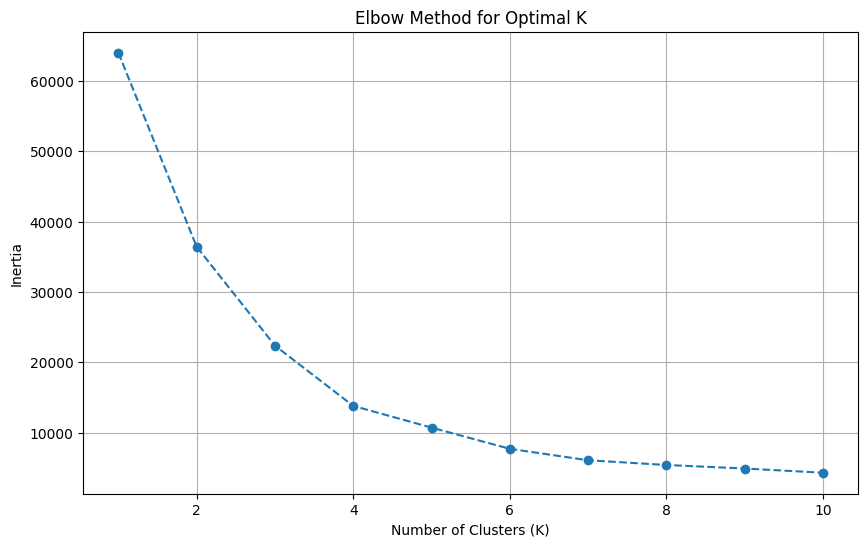

In [103]:
# Elbow Method for determining the optimal number of clusters
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid()
plt.show()

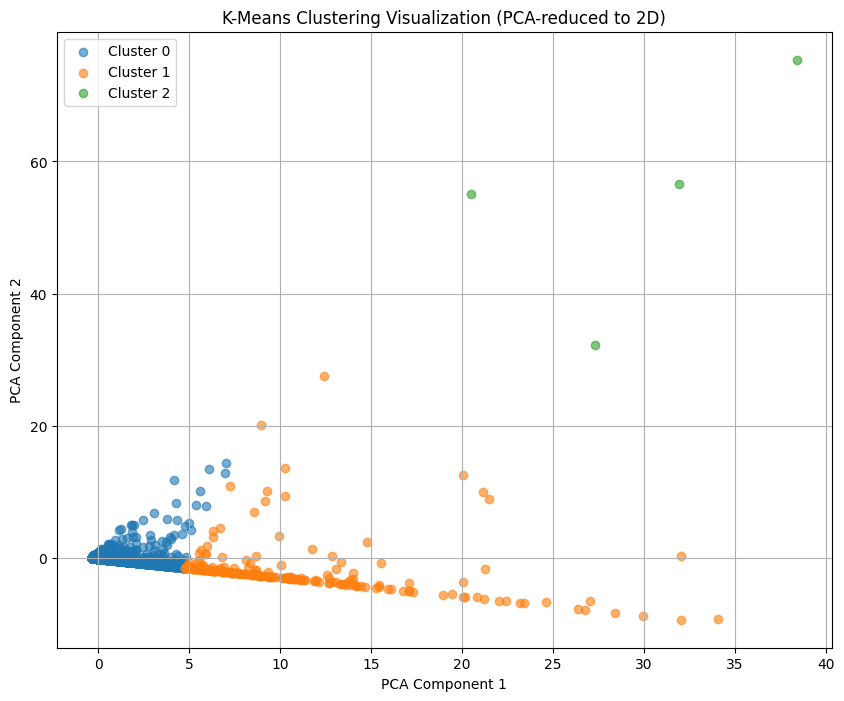

In [104]:
# Apply K-Means Clustering
optimal_k = 3  # Based on Elbow Plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# PCA for reducing dimensions to visualize clusters
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 8))
for cluster in range(optimal_k):
    cluster_points = reduced_data[clusters == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', alpha=0.6)

plt.title('K-Means Clustering Visualization (PCA-reduced to 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

In [105]:
# Print available columns to understand the structure of cluster_summary
print(cluster_summary.columns)

NameError: name 'cluster_summary' is not defined

In [ ]:
# Recommendations based on clustering
print("\nRecommendations:")

for idx, description in cluster_summary.iterrows():
    if description['Port Type_Level 1'] > 1.0:
        print(f"Cluster {idx}: Consider providing incentives for off-peak charging.")
    else:
        print(f"Cluster {idx}: Users could be encouraged to use charging facilities more frequently.")


Recommendations:
Cluster 0: Users could be encouraged to use charging facilities more frequently.
Cluster 1: Consider providing incentives for off-peak charging.
Cluster 2: Consider providing incentives for off-peak charging.


Cluster Summary:
         Model Number_Unknown  Port Type_Level 1  Port Type_Level 2
Cluster                                                            
0                    7.774953           0.103700           7.671252
1                  324.647287           4.744186         319.903101
2                  556.000000         261.750000         294.250000


<Figure size 1400x700 with 0 Axes>

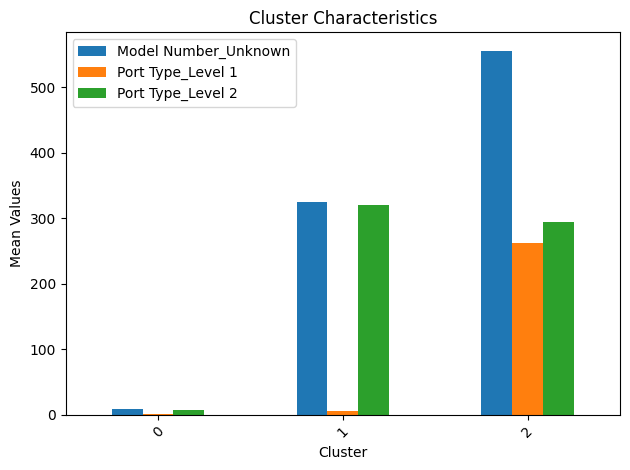


Recommendations:


KeyError: 'Energy (kWh)'

In [ ]:
# Adding cluster labels to the original dataset
aggregated_data['Cluster'] = clusters

# Analyze the cluster characteristics
cluster_summary = aggregated_data.groupby('Cluster').mean()
print("Cluster Summary:")
print(cluster_summary)

# Visualizing Cluster Characteristics
plt.figure(figsize=(14, 7))
cluster_summary.plot(kind='bar', title='Cluster Characteristics')
plt.xlabel('Cluster')
plt.ylabel('Mean Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Recommendations based on clustering
print("\nRecommendations:")
for idx, description in cluster_summary.iterrows():
    if description['Energy (kWh)'] > 1.0:
        print(f"Cluster {idx}: Consider providing incentives for off-peak charging.")
    else:
        print(f"Cluster {idx}: Users could be encouraged to use charging facilities more frequently.")

### **1: Infrastructure planning**

### **2: Campaigns to increase**

# **Conclusions**
---

# **Word Count**
---

In [ ]:
import json

with open('new_2.ipynb') as json_file:
    data = json.load(json_file)

print(data)

{'cells': [{'cell_type': 'code', 'execution_count': 379, 'metadata': {}, 'outputs': [], 'source': ['import warnings                               \n', "warnings.filterwarnings('ignore')\n", '\n', 'import pandas as pd\n', 'import numpy as np\n', 'import matplotlib.pyplot as plt\n', 'import seaborn as sns\n', 'from sklearn.preprocessing import StandardScaler, LabelEncoder\n', 'from sklearn.cluster import KMeans\n', 'from sklearn.metrics import silhouette_score\n', 'from sklearn.decomposition import PCA\n', 'import pytz\n', '\n', 'from sklearn.ensemble import RandomForestRegressor\n', 'from sklearn.metrics import mean_squared_error, mean_absolute_error\n', '\n', 'from tensorflow.keras.models import Sequential\n', 'from tensorflow.keras.layers import Dense']}, {'cell_type': 'markdown', 'metadata': {}, 'source': ['# **Introduction to the data**']}, {'cell_type': 'code', 'execution_count': 380, 'metadata': {}, 'outputs': [{'data': {'text/html': ['<div>\n', '<style scoped>\n', '    .dataframe

In [ ]:
wordCount = 0
for each in data['cells']:
    cellType = each['cell_type']
    if cellType == "markdown":
        content = each['source']
        for line in content:
            temp = [word for word in line.split() if "#" not in word] # we might need to filter for more markdown keywords here
            wordCount = wordCount + len(temp)
            
print(wordCount)

27


---

Max 4 sider

In [ ]:
A4_tegn = 2400
to_sider = A4_tegn * 4
print(to_sider)

4800
